Correct the log distance ratios for the size-limited selection of the SGA.

In [1]:
import numpy as np

from astropy.io import fits
from astropy.table import Table, join
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy import units as u

from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import norm, binned_statistic
from scipy.integrate import quad

import pickle

from tqdm import tqdm

import emcee

from corner import corner

import matplotlib.pyplot as plt

# Import data

## Fuji data

In [2]:
filename = 'SGA_fuji_jointTFR-varyV0-perpdwarf-zCMB_moduli.fits'

hdul = fits.open(filename)
SGA_TF = Table(hdul[1].data)
hdr = hdul[0].header
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p33R26,V_0p33R26_ERR,TARGETID,PHOTSYS,Z_DESI_CMB,R_MAG_SB26_CORR,R_MAG_SB26_ERR_CORR,MU_zCMB,MU_zCMB_ERR,R_ABSMAG_SB26,R_ABSMAG_SB26_ERR,R_ABSMAG_SB26_CORR,R_ABSMAG_SB26_CORR_ERR,R_ABSMAG_SB26_TFbright,R_ABSMAG_SB26_TFbright_err,MU_TFbright,MU_TFbright_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
896,SGA-2020 896,PGC1190469,1190469,180.38184750000002,1.2958311000000002,Sc,76.42,0.44771332,0.7726806,0.022478215,23.47448,16.591,False,LEDA-20181114,256,PGC1190469,1,True,180.38184750000002,1.2958311000000002,0.44771332,1803p012,180.38182702766252,1.2958268307578154,0.6239483,SB26,76.93204,0.79918337,180.38178401011206,1.295990493861164,16.25661,7.6343946,7.3312407,7.215459,4.267071,6.71145,8.98399,11.085844,12.783826,14.283976,15.799797,17.191736,18.718449,18.022089,17.380363,16.982048,17.370085,16.760023,16.377943,16.967363,16.3918,16.024693,16.728146,16.17214,15.817478,16.609686,16.06539,15.715597,16.54587,16.008068,15.658699,16.505327,15.967604,15.619181,16.48057,15.942226,15.594475,16.459711,15.924162,15.572447,0.02403138,0.037713606,0.06752815,0.0597593,0.041663416,0.057950046,0.06897008,0.07238169,0.11818266,0.0070740557,0.008179923,0.008415725,0.005835994,0.006626628,0.0068130954,0.0056522293,0.006152283,0.0062183426,0.0057331356,0.0059468574,0.0059097866,0.005547482,0.0057424223,0.005712396,0.005370375,0.0055686547,0.00

## SGA catalog

In [3]:
SGA_path = '/global/cfs/cdirs/cosmo/data/sga/2020/'
SGA_filename = SGA_path + 'SGA-2020.fits'

hdul = fits.open(SGA_filename)
SGA = Table(hdul['ELLIPSE'].data)
# SGA_tractor = Table(hdul['TRACTOR'].data)
hdul.close()

# SGA = join(SGA, SGA_tractor['SGA_ID', 'TYPE', 'SERSIC', 'SHAPE_R'], keys='SGA_ID', join_type='left')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

## PV Survey TF targets

In [4]:
pv_tf  = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv/savepath_dr9_corr/pv_tf.fits')

pv_tf[:5]

OBJID,BRICKID,BRICKNAME,RA,DEC,PMRA,PMDEC,REF_EPOCH,OVERRIDE,PVTYPE,PVPRIORITY,POINTINGID,SGA_ID
int64,int32,bytes8,float64,float64,float32,float32,float32,bool,bytes3,int32,int64,int64
262,520796,2267p350,226.62204270638287,34.98227660676318,0.0,0.0,2015.5,True,TFT,1,1,1006008
262,520796,2267p350,226.62323955692426,34.98099178744529,0.0,0.0,2015.5,False,TFT,2,2,1006008
262,520796,2267p350,226.62443636990747,34.97970695638398,0.0,0.0,2015.5,True,TFT,1,3,1006008
2738,514840,2263p337,226.40142777879575,33.68537046528162,0.0,0.0,2015.5,True,TFT,1,1,4331
2738,514840,2263p337,226.40426477759235,33.68450278837041,0.0,0.0,2015.5,False,TFT,2,2,4331


In [5]:
# We just want a table with the galaxies targeted for the TF sample
TF_target_SGAids, target_indices = np.unique(pv_tf['SGA_ID'], return_index=True)

SGA_targets = join(SGA, pv_tf[['SGA_ID']][target_indices], keys='SGA_ID')

# 1. Compute the size function

We're starting by defining the target sample as the full SGA.  This is technically not correct (the TF sample is a subset of the full SGA), but it's easier to start with this.

## Compute the physical size of the galaxies

**Note:** We will need to use `Z_LEDA` for the SGA because not all the SGA galaxies have been observed by DESI

In [7]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [8]:
# Mask redshift values of -99 (= missing)
SGA['Z_LEDA'][SGA['Z_LEDA'] == -99] = np.nan

dist = Distance(z=np.abs(SGA['Z_LEDA']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*(SGA['D26']*u.arcmin))

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)


SGA_TF['DIST_DESI_CMB'] = Distance(z=np.abs(SGA_TF['Z_DESI_CMB']), cosmology=Planck18_h)

SGA_TF['D26_kpc'] = 2*SGA_TF['DIST_DESI_CMB'].to('kpc')*np.tan(0.5*(SGA_TF['D26']*u.arcmin))

SGA_TF['DIST_MAX'] = 0.5*SGA_TF['D26_kpc']/np.tan(0.1*u.arcmin)


dist_targets = Distance(z=np.abs(SGA_targets['Z_LEDA']), cosmology=Planck18_h)

SGA_targets['D26_kpc'] = 2*dist_targets.to('kpc')*np.tan(0.5*SGA_targets['D26']*u.arcmin)

SGA_targets['DIST_MAX'] = 0.5*SGA_targets['D26_kpc']/np.tan(0.1*u.arcmin)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


## Plot the size function

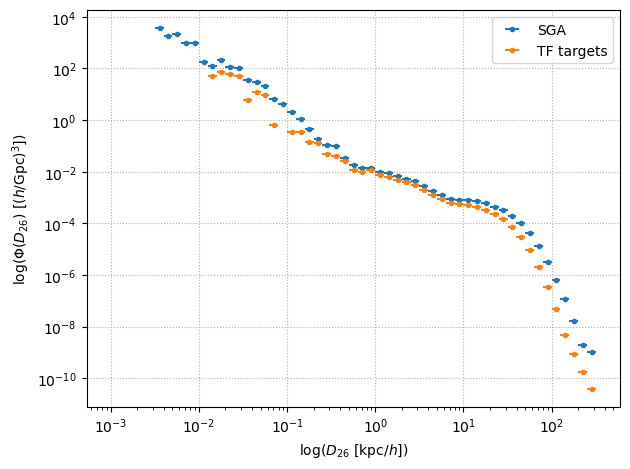

In [9]:
# D26kpc_binwidth = 5
# D26kpc_bins = np.arange(0, 200, D26kpc_binwidth)
D26kpc_bins = np.logspace(-3, 2.5, 56)
D26kpc_binwidth = D26kpc_bins[1:] - D26kpc_bins[:-1]

# ignore NaN values
good = np.isfinite(SGA['DIST_MAX']) & (SGA['DIST_MAX'] > 0)
good_targets = np.isfinite(SGA_targets['DIST_MAX']) & (SGA_targets['DIST_MAX'] > 0)

size_func, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                                    bins=D26kpc_bins, 
                                    weights=1/SGA['DIST_MAX'][good].to('Mpc').value**3, 
                                    # density=True
                                   )
N, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                            bins=D26kpc_bins)

bin_centers = bin_edges[:-1] + 0.5*D26kpc_binwidth

size_func_targets,_ = np.histogram(SGA_targets['D26_kpc'][good_targets], 
                                   bins=D26kpc_bins, 
                                   weights=1/SGA_targets['DIST_MAX'][good_targets].to('Mpc').value**3
                                  )
N_targets,_ = np.histogram(SGA_targets['D26_kpc'][good_targets], 
                           bins=D26kpc_bins)


plt.figure(tight_layout=True)

plt.errorbar(bin_centers, 
             size_func, 
             xerr=0.5*D26kpc_binwidth,  
             fmt='.', 
             label='SGA')
plt.errorbar(bin_centers, 
             size_func_targets, 
             xerr=0.5*D26kpc_binwidth, 
             fmt='.', 
             label='TF targets')

plt.grid(ls=':')

plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\Phi(D_{26})$ [($h$/Gpc)$^3$])');

In [10]:
# How incomplete is our SGA size functions by using LEDA redshifts?
print('There are', np.sum(good), 'galaxies in the SGA size function.')
print('There are', len(SGA), 'galaxies in the SGA.')
print('The completeness of the SGA size function is', np.sum(good)/len(SGA))
print('------------------')
print('There are', np.sum(good_targets), 'galaxies in the TF targets size function.')
print('There are', len(SGA_targets), 'galaxies in the TF target sample.')
print('The completeness of the TF target size function is', np.sum(good_targets)/len(SGA_targets))

There are 267753 galaxies in the SGA size function.
There are 383620 galaxies in the SGA.
The completeness of the SGA size function is 0.6979641311714718
------------------
There are 129771 galaxies in the TF targets size function.
There are 129772 galaxies in the TF target sample.
The completeness of the TF target size function is 0.9999922941774805


## Parameterize the size function

We'll try a Schechter function first:
\begin{equation}
  dn(R_{26}) = \phi(R_{26}) dR_{26} = \ln 10 \phi^* \left( \frac{R_{26}}{R_{26}^*} \right)^{\alpha + 1} e^{-R_{26}/R_{26}^*} \, d\log R_{26}
\end{equation}

In [11]:
def Schecht_log(x, dlogx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs) * dlogx


def power_log(x, dlogx, p, a, xs):
    '''
    Compute a power law (with the same form as Schechter, but no exponential 
    cutoff) for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * dlogx


def Schecht(x, dx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in linear space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.
    dx : float or ndarray of length (N,)
        bin width of x, in linear space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return p * (x/xs)**a * np.exp(-x/xs) * dx / xs


def logL(params, n, x, dx):
    '''
    Log-likelihood

    PARAMETERS
    ==========
    params : list or ndarray
        List of 2xthree parameters: scale factor, slope, and knee
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n
    dx : float or ndarray
        Bin width used to construct the histogrammed counts

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5])
    lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + Schecht_log(x, dx, 10**params[6], params[7], params[8])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + power_log(x, dx, 10**params[6], params[7], params[8])

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def nlogL(params, n, x, dx):
    '''Negative log likelihood, for minimizers'''
    return -logL(params, n, x, dx)

### Fit with `scipy.optimize.minimize`

In [50]:
# Fitting the full SGA size function
bounds1 = [[-5, 0], [-2, 0], [10, 20]]
bounds2 = [[-3, 0], [-2, 0], [1, 5]]
bounds3 = [[0, 5], [-5, 0], [0.001, 1]]

p0 = [-2.2, -0.8, 15, -1.1, -1, 2, 2, -2.5, 0.07]

bestfit = minimize(nlogL, 
                   p0, 
                   args=(size_func[N > 0], bin_centers[N > 0], 0.1), 
                   bounds=bounds1 + bounds2 + bounds3)

'''
bestfit = None

for i in range(30):

    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1 + bounds2 + bounds3]
    
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1)
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2)
    result = minimize(nlogL, p0, args=(size_func[N > 0], bin_centers[N > 0], 0.1), bounds=bounds1 + bounds2 + bounds3)

    if result.success:

        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
'''
bestfit

      fun: 493.75604173962904
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-6.88373807e-03,  1.42222233e-02,  1.70530242e-05, -2.52259726e-01,
        2.33148968e-01, -5.66160455e-03,  2.15777619e-02, -7.11963826e-02,
        1.04785158e-01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 480
      nit: 28
     njev: 48
   status: 0
  success: True
        x: array([-2.19941469, -0.80145006, 14.99999626, -1.07555201, -1.03550495,
        2.00031719,  2.04799869, -2.70425886,  0.06618088])

In [42]:
# Fitting the TF target size function
bounds1 = [[-5, 0], [-2, 0], [10, 15]]
bounds2 = [[-3, 0], [-1.5, -0.5], [1, 3]]
bounds3 = [[0, 3], [-4, -2], [0.001, 1]]

p0 = [-2.2, -0.8, 11, -1.1, -1, 1.5, 1, -3, 0.1]

bestfit_targets = minimize(nlogL, 
                   p0, 
                   args=(size_func_targets[N_targets > 0], bin_centers[N_targets > 0], 0.1), 
                   bounds=bounds1 + bounds2 + bounds3)

'''
bestfit = None

for i in range(30):

    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1 + bounds2 + bounds3]
    
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1)
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2)
    result = minimize(nlogL, p0, args=(size_func[N > 0], bin_centers[N > 0], 0.1), bounds=bounds1 + bounds2 + bounds3)

    if result.success:

        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
'''
bestfit_targets

      fun: 52.97724234149218
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.06368248e-02, -1.43160150e-02, -3.83693046e-05,  1.93294626e-01,
       -1.64043713e-01,  1.29347200e-02,  6.61632175e+00, -1.89320347e+00,
        9.38992713e+01])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 590
      nit: 25
     njev: 59
   status: 0
  success: True
        x: array([-2.20159706, -0.79900054, 10.9999969 , -1.10485331, -1.01144127,
        1.49791269,  1.49701856, -2.32685329,  0.10063642])

In [15]:
'''
# Save fit
temp_outfile = open('SGA_sizefunc-targets_20250312.pickle', 'wb')
pickle.dump((bestfit_targets), temp_outfile)
temp_outfile.close()
'''
# Load fit
temp_infile = open('../Y1/SGA_sizefunc_20250311.pickle', 'rb')
bestfit_targets = pickle.load(temp_infile)
temp_infile.close()

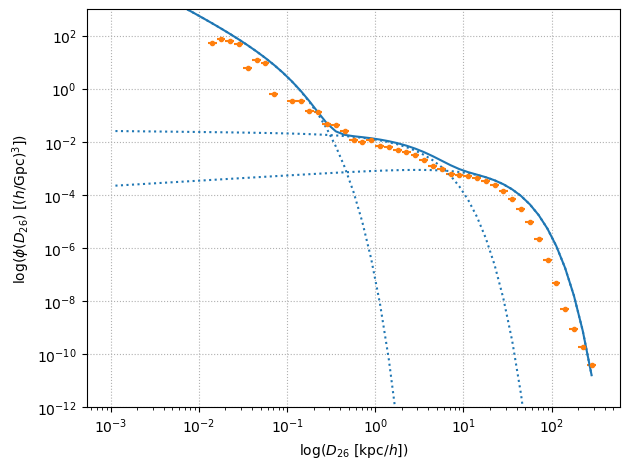

In [16]:
plt.figure(tight_layout=True)
"""
plt.errorbar(bin_centers, 
             size_func, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             # yerr=1/np.sqrt(size_func),
             fmt='.', 
             c='k')

# Actual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         # Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + power_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         # power_log(bin_centers, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         ':', c='tab:blue'
        )
'''
# Manual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 15) + Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 2) + Schecht_log(bin_centers, 0.1, 10**2, -2.5, 0.07)
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 15), # phi_* = 10**6
         ':', c='tab:orange'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 2), # phi_* = 10**7
         ':', c='tab:orange'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**2, -2.5, 0.07), # phi_* = 10**7
         ':', c='tab:orange'
        )
'''
"""

plt.errorbar(bin_centers, 
             size_func_targets, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             # yerr=1/np.sqrt(size_func),
             fmt='.', 
             c='tab:orange')

# Actual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[0], bestfit_targets.x[1], bestfit_targets.x[2]) + Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[3], bestfit_targets.x[4], bestfit_targets.x[5]) + Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[6], bestfit_targets.x[7], bestfit_targets.x[8]),
         c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[0], bestfit_targets.x[1], bestfit_targets.x[2]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[3], bestfit_targets.x[4], bestfit_targets.x[5]),
         ':', c='tab:blue'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**bestfit_targets.x[6], bestfit_targets.x[7], bestfit_targets.x[8]),
         ':', c='tab:blue'
        )
'''
# Manual fit
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 11) + Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 1.5) + Schecht_log(bin_centers, 0.1, 10**1, -3, 0.1), 
         c='tab:green'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-2.2, -0.8, 11),
         ':', c='tab:green'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**-1.1, -1, 1.5),
         ':', c='tab:green'
        )
plt.plot(bin_centers, 
         Schecht_log(bin_centers, 0.1, 10**1, -3, 0.1),
         ':', c='tab:green'
        )
'''
plt.xscale('log')
plt.yscale('log')

plt.ylim([10**-12, 10**3])

plt.grid(ls=':')

# plt.xlabel('$D_{26}$ [kpc/$h$]')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\phi(D_{26})$ [($h$/Gpc)$^3$])');

### Fit with MCMC

In [47]:
def log_prior(theta):
    
    p1, a1, xs1, p2, a2, xs2, p3, a3, xs3 = theta

    if (-5 <= p1 <= 0) and (-2 <= a1 <= 0) and (10 <= xs1 <= 15) and (-3 <= p2 <= 0) and (-1.5 <= a2 <= -0.5) and (1 <= xs2 <= 3) and (0 <= p3 <= 3) and (-4 <= a3 <= -2) and (0.001 <= xs3 <= 1):
        return 0.0
    return -np.inf


def log_probability(theta, n, x, dx):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL(theta, n, x, dx)

In [48]:
# pos = np.array([-2.2, -0.8, 15, -1.1, -1, 2, 2, -2.5, 0.07]) + 0.01*np.random.randn(32, 9)
pos = np.array([-2.2, -0.8, 11, -1.1, -1, 1.5, 1, -3, 0.1]) + 0.01*np.random.randn(32, 9)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_probability, 
                                # args=(size_func[N > 0], bin_centers[N > 0], 0.1)
                                args=(size_func_targets[N_targets > 0], bin_centers[N_targets > 0], 0.1)
                               )
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:07<00:00, 678.67it/s]


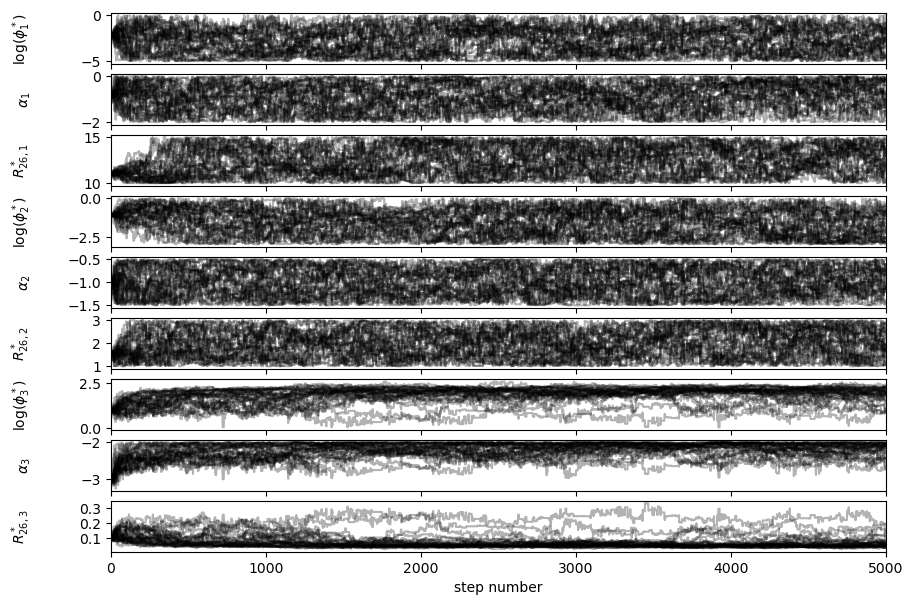

In [49]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"log($\phi_1^*$)", r"$\alpha_1$", "$R_{26,1}^*$", r"log($\phi_2^*$)", r"$\alpha_2$", "$R_{26,2}^*$", r"log($\phi_3^*$)", r"$\alpha_3$", "$R_{26,3}^*$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [50]:
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
print(flat_samples.shape)

(9600, 9)


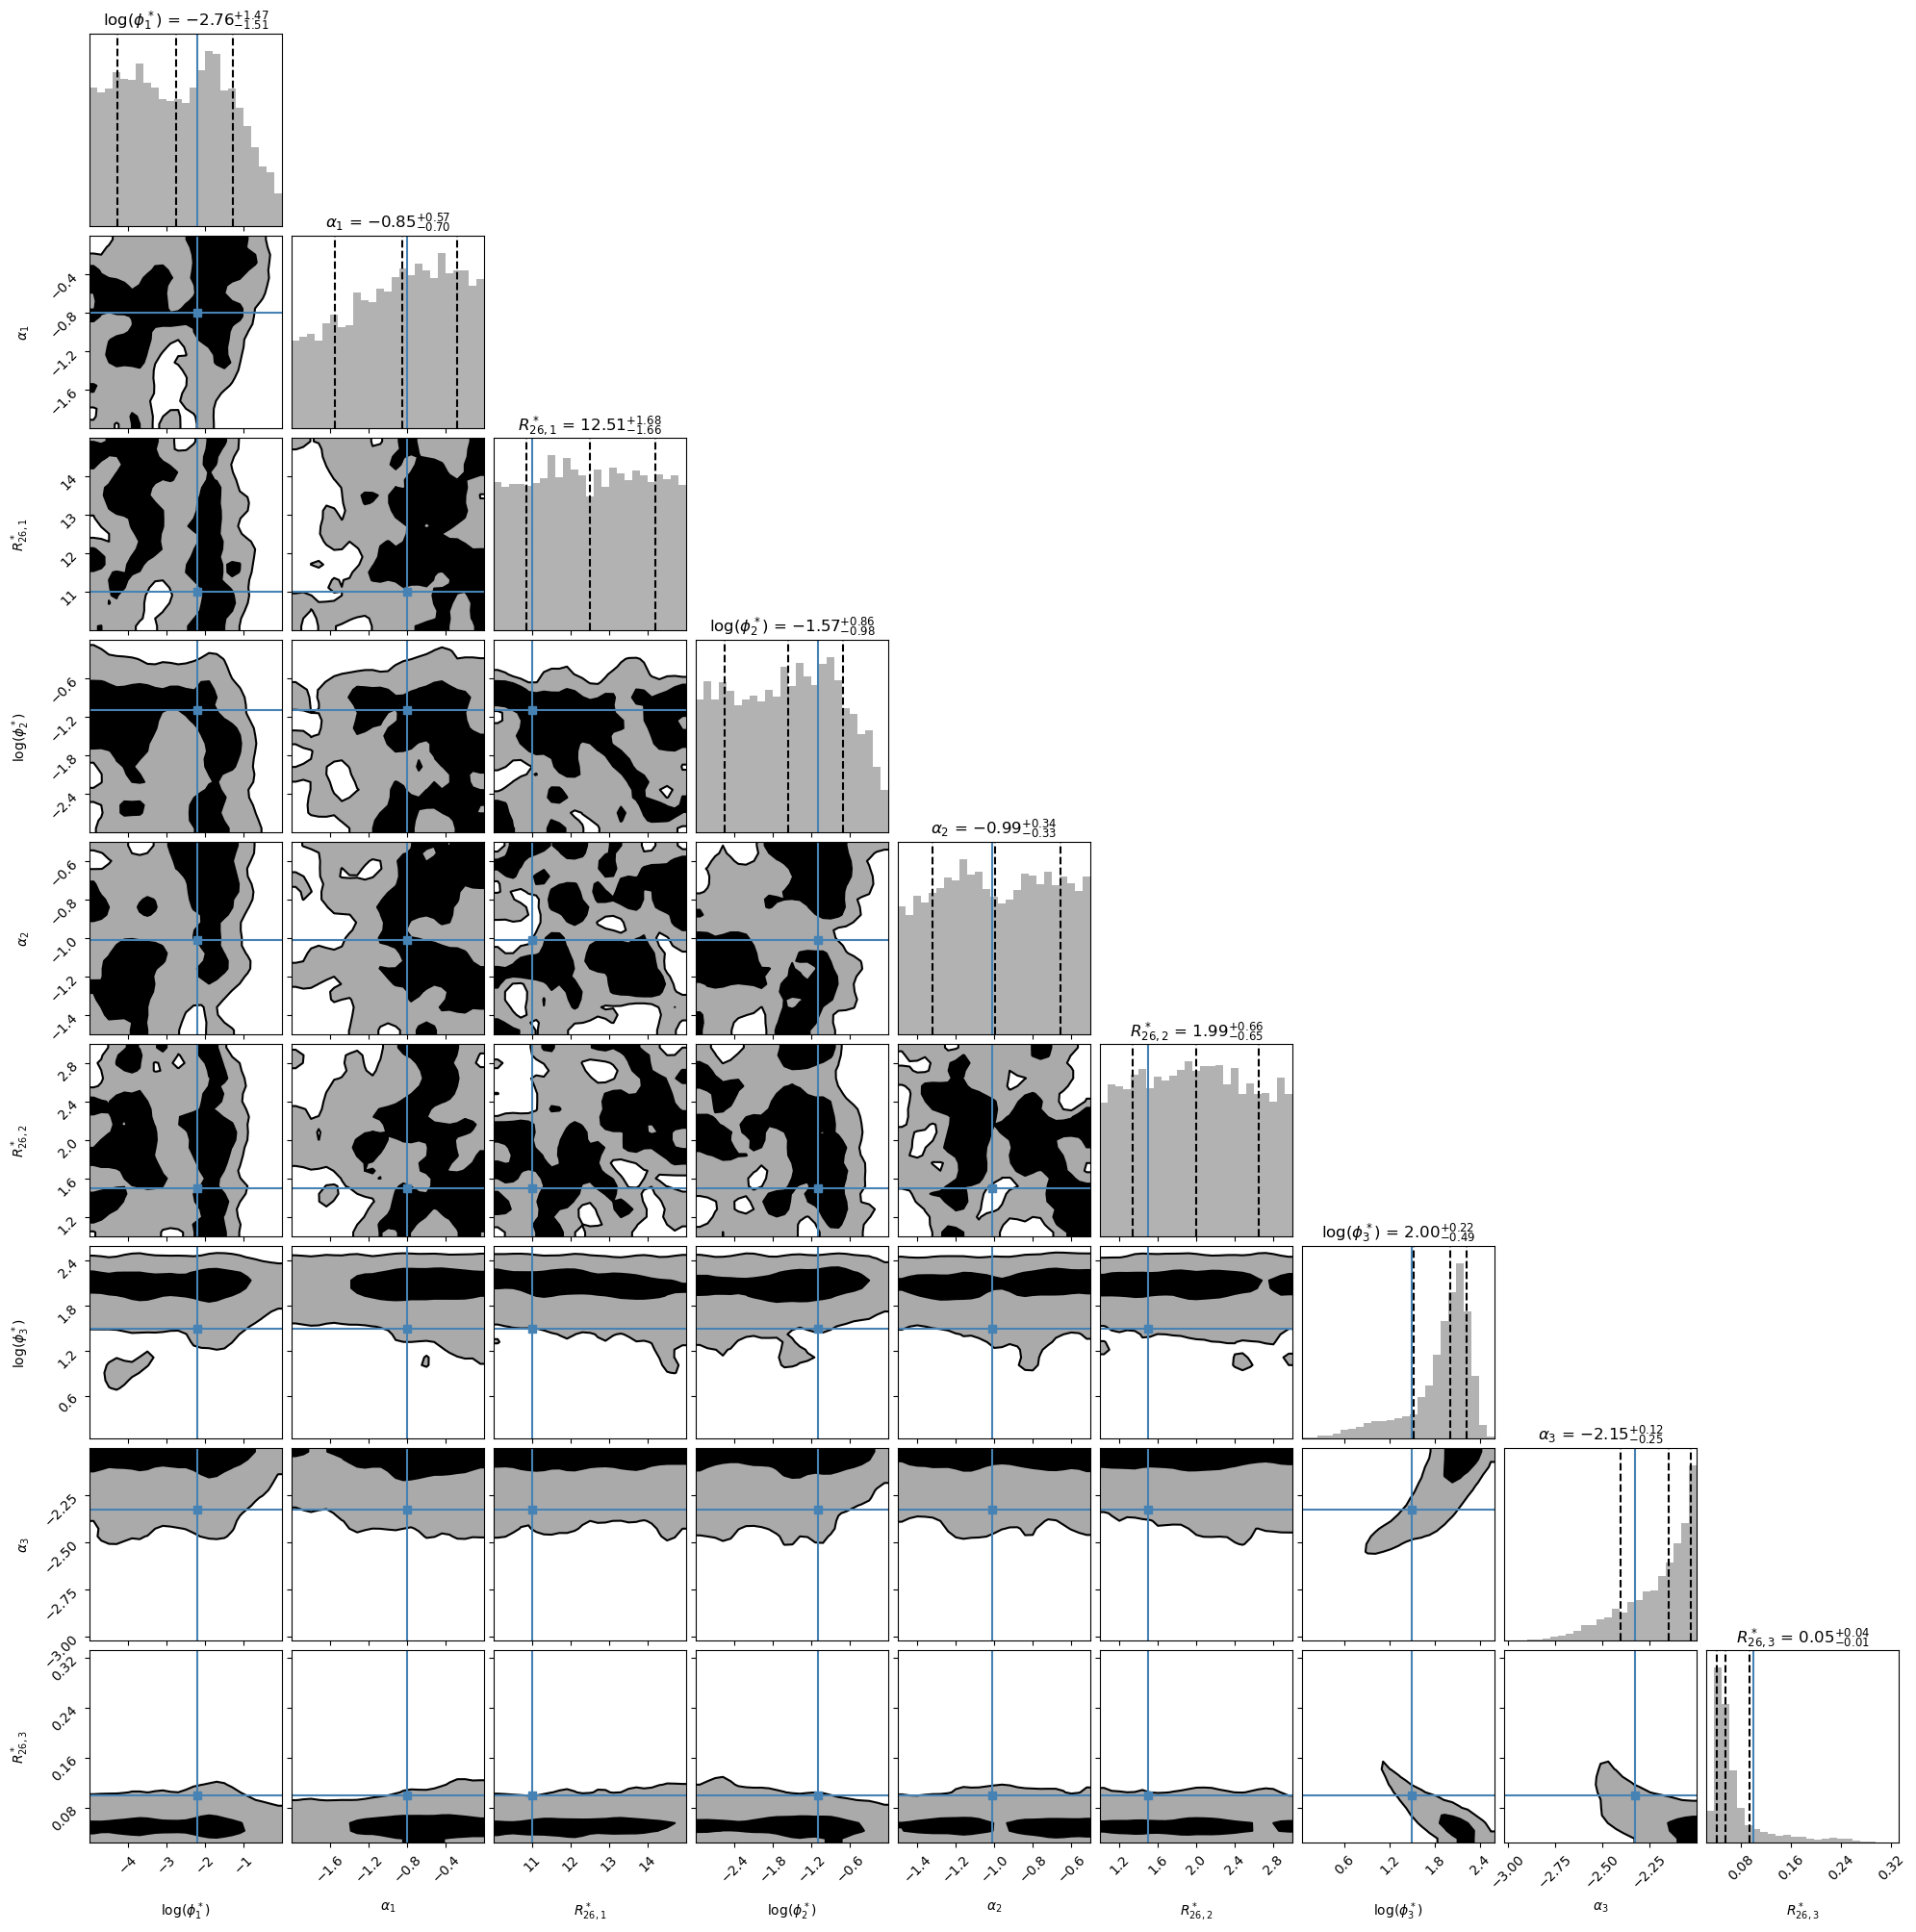

In [53]:
fig = corner(flat_samples, bins=25, smooth=1,
             truths=bestfit_targets.x,
             labels=labels, 
             levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), 
             quantiles=[0.16, 0.5, 0.84], 
             # color='tab:blue', 
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
             plot_datapoints=False,
             fill_contours=True, 
             show_titles=True);

# 2. Compute sample completeness

We define the completeness as the fraction of the targeted sample that is included in the final sample within bins of $R_{26}$.

In [17]:
# D26arcmin_binwidth = 0.1
# D26arcmin_bins = np.arange(0.2, np.max(SGA_targets['D26']) + D26arcmin_binwidth, D26arcmin_binwidth)
D26arcmin_bins = np.logspace(-1, 1.6, 27)
D26arcmin_binwidth = D26arcmin_bins[1:] - D26arcmin_bins[:-1]

N_targets, D26arcmin_bin_edges  = np.histogram(SGA_targets['D26'], bins=D26arcmin_bins)

N_obs,_ = np.histogram(SGA_TF['D26'], bins=D26arcmin_bins)

In [18]:
D26arcmin_bin_centers = D26arcmin_bin_edges[:-1] + 0.5*D26arcmin_binwidth

completeness = N_obs/N_targets

/tmp/ipykernel_1120172/3662737051.py:3: RuntimeWarning: invalid value encountered in true_divide
  completeness = N_obs/N_targets


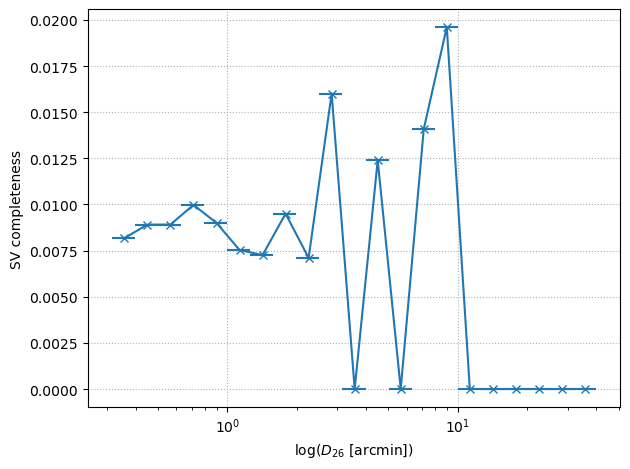

In [20]:
plt.figure(tight_layout=True)

plt.errorbar(D26arcmin_bin_centers[N_targets > 0], 
             completeness[N_targets > 0], 
             xerr=0.5*D26arcmin_binwidth[N_targets > 0],
             fmt='x-'
            )

plt.xscale('log')

plt.grid(ls=':')

plt.xlabel('log($D_{26}$ [arcmin])')
plt.ylabel('SV completeness');

# 3. Compute weights for uncorrected $\eta$ distribution

For each $\eta_i$ within 2$\sigma$ of the uncorrected $\eta$, compute its probability $w_i$, where $1/w_i$ is the completeness integrated over the size function evaluated at $\eta_i$.

In [21]:
def triple_Schecht(x, dx, params):
    '''
    Sum of three Schechter functions, in linear space
    '''
    schecht1 = Schecht(x, dx, 10**params[0], params[1], params[2])
    schecht2 = Schecht(x, dx, 10**params[3], params[4], params[5])
    schecht3 = Schecht(x, dx, 10**params[6], params[7], params[8])
    
    return schecht1 + schecht2 + schecht3

## Using the definition of $w_i$ outlined in [Springob et al. (2015)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.1886S/abstract)

\begin{equation}
  \frac{1}{w_i} = \int_0^\infty f(\eta_i) \phi(R) \, dR
\end{equation}
where $f(\eta_i)$ is the sample completeness at a distance of $d_{TF,i} = d_z 10^{-\eta_i}$

In [22]:
# Compute the integral of the size function within each D26-kpc bin
size_func_integrals = np.zeros(len(D26kpc_binwidth))

for i in range(len(D26kpc_binwidth)):
    size_func_integrals[i] = quad(triple_Schecht, 
                                  bin_edges[i], 
                                  bin_edges[i+1], 
                                  args=(1, bestfit_targets.x)
                                 )[0]

In [23]:
SGA_TF['LOGDIST_CORR1'] = np.nan
SGA_TF['LOGDIST_ERR_CORR1'] = np.nan

N_samples = 100

# i = 0
for i in tqdm(range(len(SGA_TF))):

    # Define PDF for uncorrected (measured) log distance ratio
    logdist_pdf_original = norm(loc=SGA_TF['LOGDIST'][i], scale=SGA_TF['LOGDIST_ERR'][i])
    
    logdist_values = np.linspace(SGA_TF['LOGDIST'][i] - 2*SGA_TF['LOGDIST_ERR'][i], 
                                 SGA_TF['LOGDIST'][i] + 2*SGA_TF['LOGDIST_ERR'][i], 
                                 N_samples)
    
    # Compute the TF distance corresponding to each of these logdist values
    TFdist = SGA_TF['DIST_DESI_CMB'][i]*SGA_TF['DIST_DESI_CMB'].unit*10**(-logdist_values)
    
    # Initialize new weights
    w = np.zeros(N_samples)
    
    # For each of these distances...
    for j in range(N_samples):
        
        # Convert the diameter to kpc/h 
        D26kpc_target = 2*TFdist[j].to('kpc')*np.tan(0.5*SGA_targets['D26']*u.arcmin)
        D26kpc_obs = 2*TFdist[j].to('kpc')*np.tan(0.5*SGA_TF['D26']*u.arcmin)
    
        # Compute the number of galaxies in each size bin
        Ntarget,_ = np.histogram(D26kpc_target.value, bins=D26kpc_bins)
        Nobs,_ = np.histogram(D26kpc_obs.value, bins=D26kpc_bins)
    
        # Compute the fraction of galaxies observed in each bin (the completeness)
        completeness = Nobs/Ntarget
        # Set all non-value completeness values to 0
        completeness[~np.isfinite(completeness)] = 0
        
        # For each log distance value within 2sigma of the measured value, compute its new weight
        w[j] = 1/np.sum(completeness*size_func_integrals)
    
    # Compute the corrected PDF for the log distance ratio
    logdist_pdf_corrected = w*logdist_pdf_original.pdf(logdist_values)
    
    # Compute the corrected log distance ratio
    SGA_TF['LOGDIST_CORR1'][i] = np.average(logdist_values, 
                                           weights=logdist_pdf_corrected)
    
    # Compute the corrected log distance ratio uncertainty
    # from https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
    SGA_TF['LOGDIST_ERR_CORR1'][i] = np.sqrt(np.average((logdist_values - SGA_TF['LOGDIST_CORR1'][i])**2, 
                                                       weights=logdist_pdf_corrected))

/tmp/ipykernel_1120172/1181649219.py:34: RuntimeWarning: invalid value encountered in true_divide
  completeness = Nobs/Ntarget
100%|██████████| 1164/1164 [22:12<00:00,  1.15s/it]


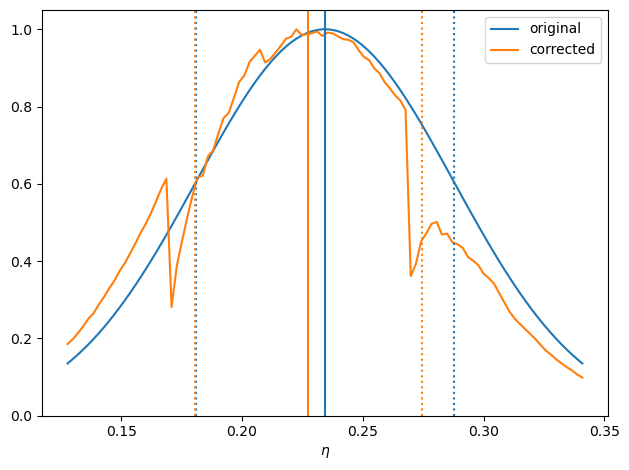

In [26]:
plt.figure(tight_layout=True)

plt.plot(logdist_values, logdist_pdf_original.pdf(logdist_values)/np.max(logdist_pdf_original.pdf(logdist_values)), label='original')
plt.plot(logdist_values, logdist_pdf_corrected/np.max(logdist_pdf_corrected), label='corrected')

plt.vlines([SGA_TF['LOGDIST'][-1] - SGA_TF['LOGDIST_ERR'][-1], SGA_TF['LOGDIST'][-1], SGA_TF['LOGDIST'][-1] + SGA_TF['LOGDIST_ERR'][-1]],
           0, 1.1, colors='tab:blue', 
           linestyles=['dotted', 'solid', 'dotted'])
plt.vlines([SGA_TF['LOGDIST_CORR1'][-1] - SGA_TF['LOGDIST_ERR_CORR1'][-1], SGA_TF['LOGDIST_CORR1'][-1], SGA_TF['LOGDIST_CORR1'][-1] + SGA_TF['LOGDIST_ERR_CORR1'][-1]],
           0, 1.1, colors='tab:orange', 
           linestyles=['dotted', 'solid', 'dotted'])

plt.ylim((0,1.05))

plt.legend()

plt.xlabel('$\eta$');

In [27]:
def profile_histogram(x, y, xbins, yerr=None, weights=None, median=False, weighted=False):
    """Compute a profile histogram from scattered data.
    
    Parameters
    ----------
    x : list or ndarray
        Ordinates (independent variable).
    y : list or ndarray
        Coordinates (dependent variable).
    xbins : list or ndarray
        Bin edges for the independent variable.
    yerr : list or ndarray
        Uncertainties on the dependent variable. Assumed independent.
    weights : list or ndarray
        If not None (and weighted=True), will use this instead of yerr to weight 
        the summary statistics.
    median : bool
        If true, compute median as central value; else, the (weighted) mean.
    weighted : bool
        Weight the summary statistics, either by the uncertainty in y or the 
        provided weights.
        
    Returns
    -------
    N : ndarray
        Unweighted counts per bin.
    h : ndarray
        Summary statistic (mean or median) of independent variable per bin.
    e : ndarray
        Uncertainty on the summary statistic per bin.
    """
    
    N = binned_statistic(x, y, bins=xbins, statistic='count').statistic

    if weighted:
        if (yerr is None) and (weights is None):
            raise ValueError('need to define either yerr or weights if using weighted fit.')

        if weights is None:
            # weight based on yerr
            w = 1/yerr**2
        else:
            w = weights
        W, H, E = binned_statistic(x, [w, w*y, w*y**2], bins=xbins, statistic='sum').statistic
        h = H/W
        e = 1/np.sqrt(W)
    else:
        mean, mean2 = binned_statistic(x, [y, y**2], bins=xbins, statistic='mean').statistic
        h = mean
        e = np.sqrt((mean2 - mean**2) / (N - 1))

    if median:
        h = binned_statistic(x, y, bins=xbins, statistic='median').statistic
    
    return N, h, e

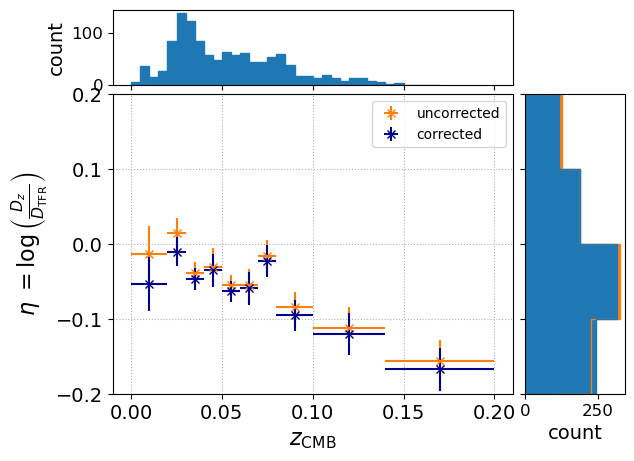

In [30]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

dwarf_boolean = np.zeros(len(SGA_TF), dtype='bool')

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
'''
# Uncorrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            color='tab:orange',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Corrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST_CORR'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR'][~dwarf_boolean],
            fmt='o', 
            color='tab:blue',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST_CORR'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')
'''
# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean], 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='tab:orange', label='uncorrected')
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST_CORR1'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR_CORR1'][~dwarf_boolean], 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='corrected')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=16)
ax.set_ylabel(r'$\eta\ = \log \left(\frac{D_z}{D_{\text{TFR}}}\right)$', fontsize=16)

ax.set_ylim((-0.2, 0.2))

ax.legend()


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.tick_params(axis='y', labelsize=12)
ax_histx.set_ylabel('count', fontsize=14)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
# Uncorrected
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:orange')
ax_histy.hist(SGA_TF['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:orange')
# Corrected
ax_histy.hist(SGA_TF['LOGDIST_CORR1'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:blue')
ax_histy.hist(SGA_TF['LOGDIST_CORR1'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST_CORR1'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.tick_params(axis='x', labelsize=12)
ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_logdist-v-zCMB_jointTFR-varyV0-perpdwarfs_20250217.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

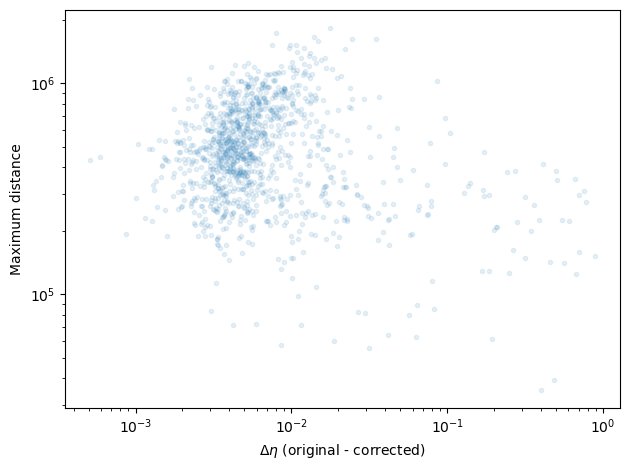

In [32]:
plt.figure(tight_layout=True)

plt.loglog(SGA_TF['LOGDIST'] - SGA_TF['LOGDIST_CORR1'], SGA_TF['DIST_MAX'], '.', alpha=0.1)

plt.xlabel(r'$\Delta \eta$ (original - corrected)')
plt.ylabel('Maximum distance');

## Using a modified definition of $w_i$

\begin{equation}
  w_i = \frac{\phi(R_i)}{\int_{R_{min}(d_i)}^\infty \phi(R) \, dR}
\end{equation}

where $R_i = d_i \tan R_{26}$, $d_i = d_z 10^{-\eta_i}$, $R_{min}(d_i)$ is the minimum galaxy size that could be observed at a distance $d_i$, and $R_{26}$ is the apparent (observed) size of the galaxy.

In [33]:
SGA_TF['LOGDIST_CORR2'] = np.nan
SGA_TF['LOGDIST_ERR_CORR2'] = np.nan

N_samples = 100

# i = 0
for i in tqdm(range(len(SGA_TF))):

    # Define PDF for uncorrected (measured) log distance ratio
    logdist_pdf_original = norm(loc=SGA_TF['LOGDIST'][i], scale=SGA_TF['LOGDIST_ERR'][i])
    
    logdist_values = np.linspace(SGA_TF['LOGDIST'][i] - 2*SGA_TF['LOGDIST_ERR'][i], 
                                 SGA_TF['LOGDIST'][i] + 2*SGA_TF['LOGDIST_ERR'][i], 
                                 N_samples)
    
    # Compute the TF distance corresponding to each of these logdist values
    TFdist = SGA_TF['DIST_DESI_CMB'][i]*SGA_TF['DIST_DESI_CMB'].unit*10**(-logdist_values)
    
    # Convert the diameter to kpc/h
    Di = 2*TFdist.to('kpc')*np.tan(0.5*SGA_TF['D26'][i]*u.arcmin)

    # Compute the value of the size function at this diameter
    # - Might eventually want to include the completeness into this term
    size_func_Di = triple_Schecht(Di.value, 1, bestfit.x)

    # Compute the minimum galaxy size that could be observed at this distance
    Dmin = 2*TFdist.to('kpc')*np.tan(0.1*u.arcmin)
    
    # Initialize new weights
    w = np.zeros(N_samples)
    
    # For each of these minimum sizes...
    for j in range(N_samples):
    
        # Integrate the size function from Dmin to infinity
        size_func_Dmin = quad(triple_Schecht, Dmin[j].value, np.infty, args=(1, bestfit.x))[0]
        
        # For each log distance value within 2sigma of the measured value, compute its new weight
        w[j] = size_func_Di[j]/size_func_Dmin
    
    # Compute the corrected PDF for the log distance ratio
    logdist_pdf_corrected = w*logdist_pdf_original.pdf(logdist_values)
    
    # Compute the corrected log distance ratio
    SGA_TF['LOGDIST_CORR2'][i] = np.average(logdist_values, 
                                           weights=logdist_pdf_corrected)
    
    # Compute the corrected log distance ratio uncertainty
    # from https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
    SGA_TF['LOGDIST_ERR_CORR2'][i] = np.sqrt(np.average((logdist_values - SGA_TF['LOGDIST_CORR2'][i])**2, 
                                                       weights=logdist_pdf_corrected))

100%|██████████| 1164/1164 [02:39<00:00,  7.30it/s]


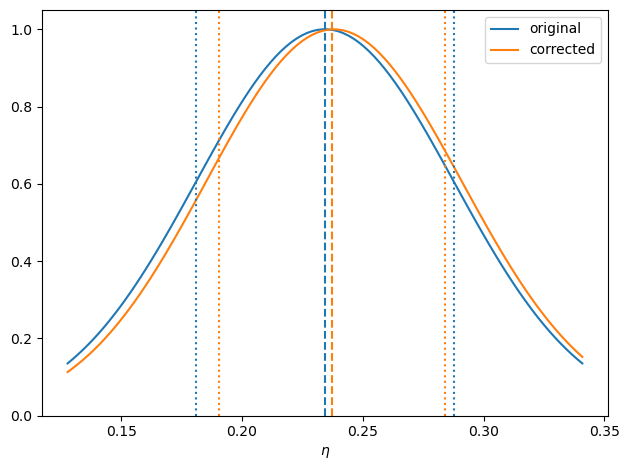

In [35]:
plt.figure(tight_layout=True)

plt.plot(logdist_values, logdist_pdf_original.pdf(logdist_values)/np.max(logdist_pdf_original.pdf(logdist_values)), label='original')
plt.plot(logdist_values, logdist_pdf_corrected/np.max(logdist_pdf_corrected), label='corrected')
# plt.plot(logdist_values, w/np.max(w), label='weights')

plt.vlines([SGA_TF['LOGDIST'][i] - SGA_TF['LOGDIST_ERR'][i], SGA_TF['LOGDIST'][i], SGA_TF['LOGDIST'][i] + SGA_TF['LOGDIST_ERR'][i]],
           0, 1.1, colors='tab:blue', 
           linestyles=['dotted', 'dashed', 'dotted'])
plt.vlines([SGA_TF['LOGDIST_CORR2'][i] - SGA_TF['LOGDIST_ERR_CORR2'][i], 
            SGA_TF['LOGDIST_CORR2'][i], 
            SGA_TF['LOGDIST_CORR2'][i] + SGA_TF['LOGDIST_ERR_CORR2'][i]],
           0, 1.1, colors='tab:orange', 
           linestyles=['dotted', 'dashed', 'dotted'])

plt.ylim((0,1.05))

plt.legend()

plt.xlabel('$\eta$');

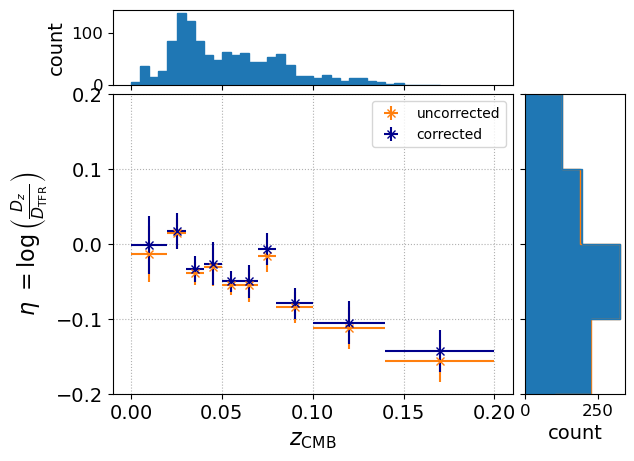

In [37]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

dwarf_boolean = np.zeros(len(SGA_TF), dtype='bool')

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
'''
# Uncorrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            color='tab:orange',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Corrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST_CORR'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR'][~dwarf_boolean],
            fmt='o', 
            color='tab:blue',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST_CORR'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')
'''
# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean], 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='tab:orange', label='uncorrected')
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST_CORR2'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR_CORR2'][~dwarf_boolean], 
                                    median=True)
ax.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='corrected')

ax.grid(ls=':')

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=16)
ax.set_ylabel(r'$\eta\ = \log \left(\frac{D_z}{D_{\text{TFR}}}\right)$', fontsize=16)

ax.set_ylim((-0.2, 0.2))

ax.legend()


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.tick_params(axis='y', labelsize=12)
ax_histx.set_ylabel('count', fontsize=14)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
# Uncorrected
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:orange')
ax_histy.hist(SGA_TF['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:orange')
# Corrected
ax_histy.hist(SGA_TF['LOGDIST_CORR2'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:blue')
ax_histy.hist(SGA_TF['LOGDIST_CORR2'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST_CORR2'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.tick_params(axis='x', labelsize=12)
ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_logdist-v-zCMB_jointTFR-varyV0-perpdwarfs_20250217.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');

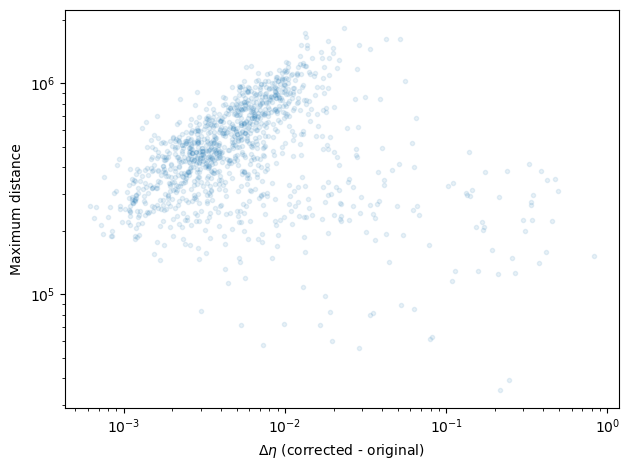

In [38]:
plt.figure(tight_layout=True)

plt.loglog(SGA_TF['LOGDIST_CORR2'] - SGA_TF['LOGDIST'], SGA_TF['DIST_MAX'], '.', alpha=0.1)

plt.xlabel(r'$\Delta \eta$ (corrected - original)')
plt.ylabel('Maximum distance');

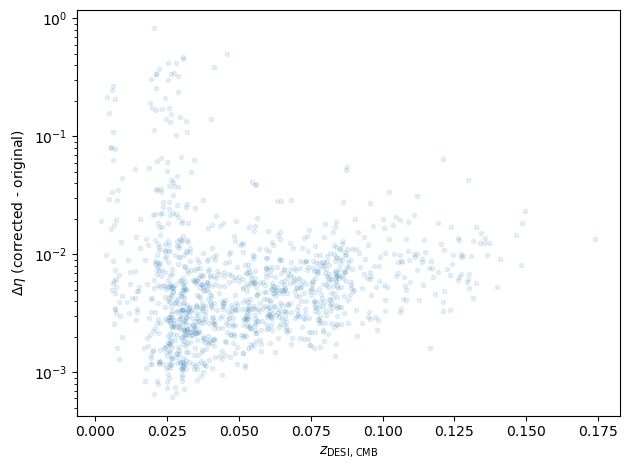

In [39]:
plt.figure(tight_layout=True)

plt.semilogy(SGA_TF['Z_DESI_CMB'], SGA_TF['LOGDIST_CORR2'] - SGA_TF['LOGDIST'], '.', alpha=0.1)

plt.ylabel(r'$\Delta \eta$ (corrected - original)')
plt.xlabel(r'$z_{\text{DESI, CMB}}$');

## Using a modified definition of $w_i$ with the completeness factored in

\begin{equation}
  w_i = \frac{f\phi(R_i)}{\int_{R_{min}(d_i)}^\infty f\phi(R) \, dR}
\end{equation}

where $f$ is the sample completeness at $\eta_i$, $R_i = d_i \tan R_{26}$, $d_i = d_z 10^{-\eta_i}$, $R_{min}(d_i)$ is the minimum galaxy size that could be observed at a distance $d_i$, and $R_{26}$ is the apparent (observed) size of the galaxy.

In [40]:
SGA_TF['LOGDIST_CORR3'] = np.nan
SGA_TF['LOGDIST_ERR_CORR3'] = np.nan

N_samples = 100

# i = 0
for i in tqdm(range(len(SGA_TF))):

    # Define PDF for uncorrected (measured) log distance ratio
    logdist_pdf_original = norm(loc=SGA_TF['LOGDIST'][i], scale=SGA_TF['LOGDIST_ERR'][i])
    
    logdist_values = np.linspace(SGA_TF['LOGDIST'][i] - 2*SGA_TF['LOGDIST_ERR'][i], 
                                 SGA_TF['LOGDIST'][i] + 2*SGA_TF['LOGDIST_ERR'][i], 
                                 N_samples)
    
    # Compute the TF distance corresponding to each of these logdist values
    TFdist = SGA_TF['DIST_DESI_CMB'][i]*SGA_TF['DIST_DESI_CMB'].unit*10**(-logdist_values)
    
    # Convert the diameter to kpc/h
    Di = 2*TFdist.to('kpc')*np.tan(0.5*SGA_TF['D26'][i]*u.arcmin)
    
    # Compute the value of the size function at this diameter
    size_func_Di = triple_Schecht(Di.value, 1, bestfit.x)
    
    # Determine which D26 bin the diameter falls in
    Di_index = np.digitize(Di.value, D26kpc_bins)
    # Change indices for last bin
    Di_index[Di_index == len(D26kpc_bins)] -= 1
    
    # Compute the minimum galaxy size that could be observed at this distance
    Dmin = 2*TFdist.to('kpc')*np.tan(0.1*u.arcmin)
    
    # Determine which D26 bin the minimum diameter falls in
    Dmin_index = np.digitize(Dmin.value, D26kpc_bins)
    # Change indices for last bin
    Dmin_index[Dmin_index == len(D26kpc_bins)] -= 1
    '''
    # Reshape arrays
    TFdist.shape = (N_samples, 1)
    D26_targets = np.array(SGA_targets['D26'], ndmin=2)
    D26_obs = np.array(SGA_TF['D26'], ndmin=2)
    
    # Convert the diameter to kpc/h 
    D26kpc_target = 2*TFdist.to('kpc')*np.tan(0.5*D26_targets*u.arcmin)
    D26kpc_obs = 2*TFdist.to('kpc')*np.tan(0.5*D26_obs*u.arcmin)
    
    # Compute the number of galaxies in each size bin
    target_indices = np.digitize(D26kpc_target.value, D26kpc_bins)
    Ntarget = np.zeros((D26kpc_target.shape[0], len(D26kpc_bins)-1))
    for i,index in enumerate(np.unique(target_indices)):
        Ntarget[:,i] = np.sum(target_indices==index, axis=1)
    
    obs_indices = np.digitize(D26kpc_obs.value, D26kpc_bins)
    Nobs = np.zeros((D26kpc_obs.shape[0], len(D26kpc_bins)-1))
    for i,index in enumerate(np.unique(obs_indices)):
        Nobs[:,i] = np.sum(obs_indices==index, axis=1)
    
    # Compute the fraction of galaxies observed in each bin (the completeness)
    completeness = Nobs/Ntarget
    # Set all non-value completeness values to 0
    completeness[~np.isfinite(completeness)] = 0
    '''
    # Initialize new weights
    w = np.zeros(N_samples)
    
    # For each of these minimum sizes...
    for j in range(N_samples):
    
        # Convert the diameter to kpc/h 
        D26kpc_target = 2*TFdist[j].to('kpc')*np.tan(0.5*SGA_targets['D26']*u.arcmin)
        D26kpc_obs = 2*TFdist[j].to('kpc')*np.tan(0.5*SGA_TF['D26']*u.arcmin)
    
        # Compute the number of galaxies in each size bin
        Ntarget,_ = np.histogram(D26kpc_target.value, bins=D26kpc_bins)
        Nobs,_ = np.histogram(D26kpc_obs.value, bins=D26kpc_bins)
    
        # Compute the fraction of galaxies observed in each bin (the completeness)
        completeness = Nobs/Ntarget
        # Set all non-value completeness values to 0
        completeness[~np.isfinite(completeness)] = 0
    
        # Integrate just the bin within which Dmin falls
        size_func_integral_Dmin = quad(triple_Schecht, 
                                       Dmin[j].value, 
                                       D26kpc_bins[Dmin_index[j]], 
                                       args=(1, bestfit.x)
                                      )[0]
    
        # Make new integrals array, placing 0s for all bins less than this Dmin
        size_func_int = np.zeros(len(size_func_integrals))
        size_func_int[Dmin_index[j] - 1] = size_func_integral_Dmin
        size_func_int[Dmin_index[j]:] = size_func_integrals[Dmin_index[j]:]
        
        # For each log distance value within 2sigma of the measured value, compute its new weight
        # w[j] = (completeness[j, Di_index[j]]*size_func_Di[j])/np.nansum(completeness[j]*size_func_int)
        w[j] = (completeness[Di_index[j] - 1]*size_func_Di[j])/np.nansum(completeness*size_func_int)
    
    # Compute the corrected PDF for the log distance ratio
    logdist_pdf_corrected = w*logdist_pdf_original.pdf(logdist_values)
    
    # Compute the corrected log distance ratio
    SGA_TF['LOGDIST_CORR3'][i] = np.average(logdist_values, 
                                            weights=logdist_pdf_corrected)
    
    # Compute the corrected log distance ratio uncertainty
    # from https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-numpy
    SGA_TF['LOGDIST_ERR_CORR3'][i] = np.sqrt(np.average((logdist_values - SGA_TF['LOGDIST_CORR3'][i])**2, 
                                                         weights=logdist_pdf_corrected))

/tmp/ipykernel_1120172/251685419.py:78: RuntimeWarning: invalid value encountered in true_divide
  completeness = Nobs/Ntarget
 12%|█▏        | 136/1164 [02:38<19:59,  1.17s/it]


KeyboardInterrupt: 

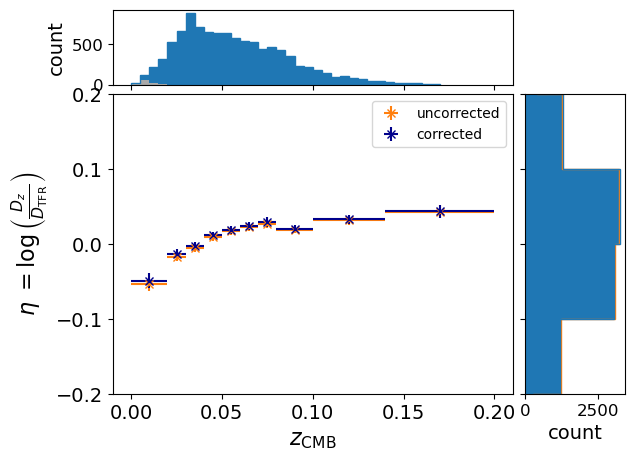

In [129]:
zbins = np.asarray([0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.14, 0.2])
dz = 0.5*np.diff(zbins)
zc = 0.5*(zbins[1:] + zbins[:-1])

dwarf_boolean = SGA_TF['DWARF'].astype('bool')

fig = plt.figure()

gs = fig.add_gridspec(2, 2, width_ratios=(4,1), height_ratios=(1,4), left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1,0])
'''
# Uncorrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean],
            fmt='o', 
            color='tab:orange',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')

# Corrected
ax.errorbar(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
            SGA_TF['LOGDIST_CORR3'][~dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][~dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR3'][~dwarf_boolean],
            fmt='o', 
            color='tab:blue',
            markersize=4, 
            alpha=0.3, 
            ecolor='gray')
ax.errorbar(SGA_TF['Z_DESI_CMB'][dwarf_boolean], 
            SGA_TF['LOGDIST_CORR3'][dwarf_boolean], 
            xerr=SGA_TF['ZERR_DESI'][dwarf_boolean], 
            yerr=SGA_TF['LOGDIST_ERR_CORR3'][dwarf_boolean],
            fmt='.', 
            color='gray',
            alpha=0.3, 
            ecolor='gray')
'''
# Plot the mean, weighted by Vmax
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR'][~dwarf_boolean], 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='tab:orange', label='uncorrected')
N, y_avg, y_std = profile_histogram(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], 
                                    SGA_TF['LOGDIST_CORR3'][~dwarf_boolean], 
                                    zbins, 
                                    yerr=SGA_TF['LOGDIST_ERR_CORR3'][~dwarf_boolean], 
                                    median=True)
plt.errorbar(zc, y_avg, xerr=dz, yerr=y_std, fmt='x', color='darkblue', label='corrected')

plt.tick_params(axis='both', which='major', labelsize=14)

ax.set_xlabel(r'$z_{\text{CMB}}$', fontsize=16)
ax.set_ylabel(r'$\eta\ = \log \left(\frac{D_z}{D_{\text{TFR}}}\right)$', fontsize=16)

ax.set_ylim((-0.2, 0.2))

ax.legend()


ax_histx = fig.add_subplot(gs[0,0], sharex=ax)
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005))
ax_histx.hist(SGA_TF['Z_DESI_CMB'][dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='darkgray')
ax_histx.hist(SGA_TF['Z_DESI_CMB'][~dwarf_boolean], bins=np.arange(0, 0.175, 0.005), color='tab:blue', histtype='step')

ax_histx.tick_params(axis='x', labelbottom=False)
ax_histx.tick_params(axis='y', labelsize=12)
ax_histx.set_ylabel('count', fontsize=14)


ax_histy = fig.add_subplot(gs[1,1], sharey=ax)
# Uncorrected
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:orange')
ax_histy.hist(SGA_TF['LOGDIST'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:orange')
# Corrected
ax_histy.hist(SGA_TF['LOGDIST_CORR3'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              color='tab:blue')
ax_histy.hist(SGA_TF['LOGDIST_CORR3'][dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              color='darkgray', 
              orientation='horizontal')
ax_histy.hist(SGA_TF['LOGDIST_CORR3'][~dwarf_boolean], 
              bins=np.arange(-2, 2, 0.1), 
              orientation='horizontal', 
              histtype='step', 
              color='tab:blue')

# ax_histy.set_xscale('log')
ax_histy.tick_params(axis='y', labelleft=False)
ax_histy.tick_params(axis='x', labelsize=12)
ax_histy.set_xlabel('count', fontsize=14);

# plt.savefig('../../Figures/SV/fuji_logdist-v-zCMB_jointTFR-varyV0-perpdwarfs_20250217.png', 
#             dpi=150, 
#             facecolor='none', 
#             bbox_inches='tight');